# U-net network for super-resolution

In [18]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

%matplotlib inline

### Load and prepare data

Modify Pytorch CIFAR10 Dataset to load both input images as target and downscaled images as input

In [19]:
from torchvision.datasets import CIFAR10
from PIL import Image

class CIFAR10_sres(CIFAR10):
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (img_x, img_y) where img_x is the resized image from 32 to 16
            and img_y is the original 32x32 image
        """
        img, target = self.data[index], self.targets[index]

        img = Image.fromarray(img)

        # Downscale input image
        if self.transform is not None:
            img_x = self.transform(img)

        if self.target_transform is not None:
            img_y = self.target_transform(img)

        return img_x, img_y

Define pytorch lightning DataModule

In [22]:
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

class CIFAR10DataModule(pl.LightningDataModule):

    def __init__(self, batch_size, data_dir: str = './data', num_workers: int = 0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # Transformations for input images
        self.transform = transforms.Compose(
            [transforms.Resize(16),
             transforms.ToTensor(),
             #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        
        # Transformations for target/label images
        self.target_transform = transforms.Compose(
            [transforms.ToTensor(),
             #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    def prepare_data(self):
        # Download
        CIFAR10_sres(self.data_dir, train=True, download=True)
        CIFAR10_sres(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            cifar10_full = CIFAR10_sres(self.data_dir, train=True, transform=self.transform, target_transform=self.target_transform)
            self.cifar10_train, self.cifar10_val = random_split(cifar10_full, [45000, 5000])

            self.dims = tuple(self.cifar10_train[0][0].shape)

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.cifar10_test = CIFAR10_sres(self.data_dir, train=False, transform=self.transform, target_transform=self.target_transform)

            self.dims = tuple(self.cifar10_test[0][0].shape)

    def train_dataloader(self):
        return DataLoader(self.cifar10_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.cifar10_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.cifar10_test, batch_size=self.batch_size, num_workers=self.num_workers)

### Define U-Net model

In [23]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ConvBlock(pl.LightningModule):
    def __init__(self, in_channels, out_channels, mid_channels=None, kernel_size=3, dropout=0):
        super().__init__()

        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            #nn.Dropout2d(dropout)
        )

    def forward(self, x):
        return self.double_conv(x)


class Up(pl.LightningModule):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ConvBlock(in_channels*2, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels*2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Unet(pl.LightningModule):
    def __init__(self, args):
        super(Unet, self).__init__()
        self.hparams = args

        # Encoder
        all_blocks_encoder = []
        for i in range(0, args.num_blocks-1):
            num_filters_in = args.filters_per_block[i]
            num_filters_out = args.filters_per_block[i+1]

            all_blocks_encoder.append(ConvBlock(num_filters_in, num_filters_out, dropout=args.dropout))

        self.encoder = nn.ModuleList(all_blocks_encoder)
        self.maxpool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(args.filters_per_block[-1], args.filters_per_block[-1])

        # Decoder
        all_blocks_decoder = []
        for i in range(1, args.num_blocks-1):
            num_filters_in = args.filters_per_block[-i]
            num_filters_out = args.filters_per_block[-i-1]
            all_blocks_decoder.append(Up(num_filters_in, num_filters_out, bilinear=args.bilinear))
        all_blocks_decoder.append(Up(num_filters_out, num_filters_out, bilinear=args.bilinear))
        
        self.decoder = nn.ModuleList(all_blocks_decoder)

        # Conv from num_filters_out of last block to original image channels
        self.out_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(num_filters_out, args.filters_per_block[0], kernel_size=args.kernel_size, padding=1),
            #nn.BatchNorm2d(args["filters_per_block"][0]),
            nn.ReLU(),
            nn.Conv2d(args.filters_per_block[0], args.filters_per_block[0], kernel_size=args.kernel_size, padding=1),
            #nn.BatchNorm2d(args["filters_per_block"][0]),
            nn.ReLU(),
        )

    def forward(self, x):

        # Encode/Down
        residual_x = []
        for block in self.encoder:
            x = block(x)
            residual_x.append(x)
            x = self.maxpool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decode/Up
        for i, block in enumerate(self.decoder):
            x = self.decoder[i](x, residual_x[-i-1])
 
        return self.out_conv(x)

### Define LightningModule for the super resolution task

In [24]:
from torch.optim.lr_scheduler import StepLR

class SuperResolutionTask(pl.LightningModule):

    def __init__(self, args):
        super().__init__()
        self.hparams = args
        self.model = Unet(self.hparams)
        
        # Loss functions parameters
        self.proportion = args.proportion
        
        # Sobel operator for gradient calculation in x direction
        weights_x = torch.tensor([[-1., -2., -1.],
                                  [0., 0., 0.],
                                  [1., 2., 1.]], requires_grad=False)
        self.kernel_x = weights_x.view(1, 1, 3, 3).repeat(1, 3, 1, 1)
        
        # Sobel operator for gradient calculation in y direction
        weights_y = torch.tensor([[-1., 0., 1.],
                                  [-2., 0., 2.],
                                  [-1., 0., 1.]], requires_grad=False)
        self.kernel_y = weights_y.view(1, 1, 3, 3).repeat(1, 3, 1, 1)
        
    def forward(self, data):
        return self.model(data)
        
    def mge_loss(self, output, target):
        self.kernel_x = self.kernel_x.to(output.device)
        self.kernel_y = self.kernel_y.to(output.device)
        
        output_grad_x = F.conv2d(output, self.kernel_x)
        output_grad_y = F.conv2d(output, self.kernel_y)
        output_grad_sqrt_sum = torch.sqrt(torch.square(output_grad_x) + torch.square(output_grad_y) + 1e-8)
        
        target_grad_x = F.conv2d(target, self.kernel_x)
        target_grad_y = F.conv2d(target, self.kernel_y)
        target_grad_sqrt_sum = torch.sqrt(torch.square(target_grad_x) + torch.square(target_grad_y) + 1e-8)
        
        image_mse_loss = torch.mean((output - target)**2)
        grad_mse_loss = torch.mean((output_grad_sqrt_sum - target_grad_sqrt_sum)**2)
        
        return image_mse_loss + self.proportion*grad_mse_loss
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.mge_loss(y_hat, y)
        return pl.TrainResult(loss)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.mge_loss(y_hat, y)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log_dict({'val_loss': loss})
        return result
    
    def test_step(self, batch, batch_idx):
        result = self.validation_step(batch, batch_idx)
        result.rename_keys({'val_loss': 'test_loss'})
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr_rate)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
        
        return [optimizer], [scheduler]

### Set hyperparameters

In [61]:
from pytorch_lightning import seed_everything
import torch
from argparse import ArgumentParser
import sys
sys.argv = ['']
args = ArgumentParser()
args = args.parse_args()

# Network hyperparameters
args.filters_per_block = np.array([3, 32, 64, 128])
args.num_blocks = len(args.filters_per_block)
args.kernel_size = 3
args.dropout = 0.1
args.bilinear = True
args.proportion = 0.0

# Set cuda if available
use_cuda = torch.cuda.is_available()
args.device = torch.device("cuda" if use_cuda else "cpu")

# Training hyperparameters
args.batch_size = 64
args.max_epochs = 10
args.lr_rate = 1e-4
args.grad_clip = 1.0

# Other hyperparameters
args.num_gpus = 1
args.num_workers = 4
args.model_save_dir = os.getcwd()+'/model_save'

# sets seeds for numpy, torch, etc...
seed_everything(2)

2

Set callback function to track and save best model based on validation loss

In [26]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath=args.model_save_dir,
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=''
)

In [35]:
from pytorch_lightning import Trainer

### Find suitable learning rate before training

In [37]:
model = SuperResolutionTask(args)
cifar10_data_module = CIFAR10DataModule(batch_size=args.batch_size, num_workers=args.num_workers)
trainer = Trainer()
lr_finder = trainer.lr_find(model, cifar10_data_module)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Files already downloaded and verified
Files already downloaded and verified



  | Name  | Type | Params
-------------------------------
0 | model | Unet | 841 K 


Saving latest checkpoint..


Plot of lr_rate vs loss value to visualize behaviour of different learning rates

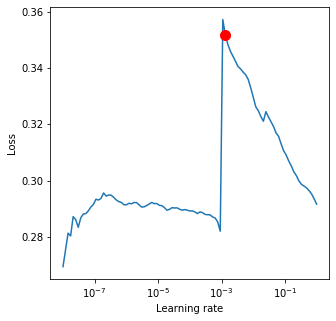

In [44]:
fig = lr_finder.plot(suggest=True)
fig.set_size_inches(5, 5)
fig.show()

In [63]:
print("Suggested learning rate", lr_finder.suggestion())
args.lr_rate = lr_finder.suggestion()

Suggested learning rate 0.0013182567385564075


### Training

In [64]:
model = SuperResolutionTask(args)
cifar10_data_module = CIFAR10DataModule(batch_size=args.batch_size, num_workers=args.num_workers)
trainer = Trainer(max_epochs = args.max_epochs, gpus=args.num_gpus, auto_select_gpus=True, checkpoint_callback=checkpoint_callback, gradient_clip_val=args.grad_clip)
trainer.fit(model, cifar10_data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [1,2]


Files already downloaded and verified
Files already downloaded and verified



  | Name  | Type | Params
-------------------------------
0 | model | Unet | 841 K 


Saving latest checkpoint..


1

### Run test datatset

In [65]:
trainer.test()

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0032, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_loss': 0.003218958619982004}]

### Load model from best checkpoint

In [66]:
model = SuperResolutionTask.load_from_checkpoint(args.model_save_dir+'/epoch=9.ckpt', args).to(args.device)
model.eval()

SuperResolutionTask(
  (model): Unet(
    (encoder): ModuleList(
      (0): ConvBlock(
        (double_conv): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (1): ConvBlock(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (2): ConvBlock(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

### Visualize prediction result on test set

In [50]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

Plot 8 images from test dataset: Input, Label and Prediction

In [67]:
num_imgs = 8
cifar10_data_module.setup('test')
data_iter = iter(cifar10_data_module.test_dataloader())
images, labels = next(data_iter)
X_test = images[:num_imgs]
Y_test = labels[:num_imgs]

Input images:


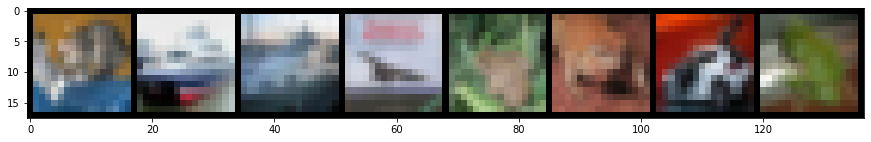

In [32]:
print("Input images:")
show(make_grid(X_test, padding=1))

Output images:


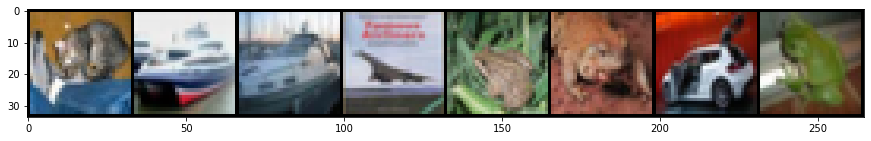

In [33]:
print("Output images:")
show(make_grid(Y_test, padding=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted images:


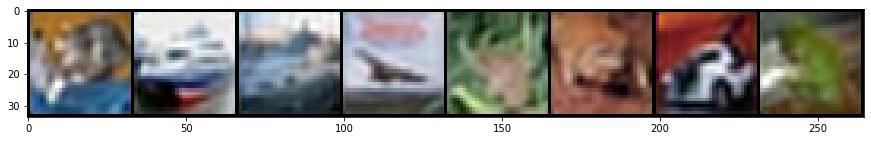

In [68]:
print("Predicted images:")
prediction = model(X_test.to(args.device))
prediction = prediction.cpu().detach()
show(make_grid(prediction, padding=1))

### Test on arbitrary size square image

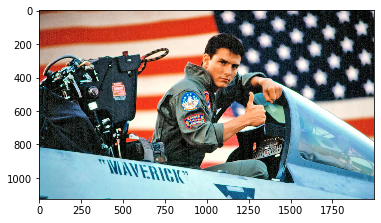

In [85]:
from PIL import Image
%matplotlib inline

image = Image.open("img48.jpg")
plt.imshow(image)

In [98]:
test_transforms = transforms.Compose([transforms.Resize((600,600)),
                                      transforms.ToTensor()
                                     ])

test_image = test_transforms(image).unsqueeze(0)

print(test_image.shape)

torch.Size([1, 3, 600, 600])


In [102]:
model = SuperResolutionTask.load_from_checkpoint(args.model_save_dir+'/epoch=9.ckpt', args).to(args.device)
model.eval()
y_pred = model(test_image.to(args.device)).detach().cpu()

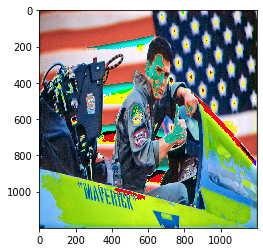

In [104]:
predicted_image = transforms.ToPILImage()(y_pred.squeeze(0))

plt.imshow(predicted_image)